In [14]:
import sys
sys.path.append('/Users/Jake/HiggsMassMeasurement/')
sys.path.append('/Users/Jake/HiggsMassMeasurement/d0_Studies/')
# import os
# import math
import vaex  # The holy grail.

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# # Neat tricks.
# from itertools import chain
from matplotlib.backends.backend_pdf import PdfPages
# from matplotlib.patches import Rectangle
from IPython.display import display
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# # Local imports. 
from vaex_Utils.vaex_dataframes import (vdf_MC_2016_DY, vdf_MC_2017_Jpsi, prepare_vaex_df)
from PyUtils.Utils_Files import make_str_title_friendly, makeDirs, check_overwrite
# from PyUtils.Utils_Physics import theta2pseudorap, pseudorap2theta, calc_dR, calc_dphi, perc_diff
# from PyUtils.Utils_StatsAndFits import gaussian, fit_with_gaussian, iterative_fit_gaus
# from PyUtils.Utils_Collection_Helpers import weave_lists
# from d0_Utils.d0_cls import KinematicBin, KinBinOrganizer, GraphLine
# from d0_Utils.d0_cls import GraphLine #KinBinOrganizer, 

# from d0_Utils.d0_fns import (make_binning_array, shift_binning_array, get_subset_mask, 
#                              make_kinem_subplot, calc_x_err_bins, combine_cut_list, calc_bin_widths,
#                              account_for_underoverflow_entries, find_equal_hist_divisions, find_equal_hist_regions_unbinned, collapse_eta_bin_edges)

from d0_Utils.d0_dicts import label_LaTeX_dict#,  color_dict,

# # Specific configurations.
plt.rcParams.update({'figure.max_open_warning': 10})    # Related to saving memory and opening plots.
pd.options.display.max_columns = None
plt.style.use('cmsstyle_plot')

# Imports below only used for temporary testing.
from PyUtils.Utils_Physics import theta2pseudorap, pseudorap2theta, calc_dR, calc_dphi, perc_diff
from PyUtils.Utils_Plotting import (change_cmap_bkg_to_white, save_plots_to_outpath, make_1D_dist, get_stats_1Dhist, 
                                    get_stats_2Dhist, hist_y_label, make_2by2_subplots_for_ratioplots,
                                    make_stats_legend_for_1dhist, make_stats_legend_for_2dhist, 
                                    make_stats_legend_for_gaus_fit)
from d0_Utils.d0_fns import (make_binning_array, centers_of_binning_array, get_subset_mask, 
                             make_kinem_subplot, calc_x_err_bins, combine_cut_list, calc_bin_widths,
#                              account_for_underoverflow_entries, 
                             find_equal_hist_divisions, find_equal_hist_regions_unbinned, collapse_eta_bin_edges)

# Develop and Deploy:

## To Do:
- [X] Make a graph.
- [ ] Make side-by-side graphs.

In [1]:
import sys
import pickle

import matplotlib.pyplot as plt
import numpy as np
plt.style.use("cmsstyle_plot")
sys.path.append('/Users/Jake/HiggsMassMeasurement/')
sys.path.append('/Users/Jake/HiggsMassMeasurement/d0_Studies/')

from d0_Utils.d0_dicts import label_LaTeX_dict, color_dict
from PyUtils.Utils_StatsAndFits import prop_err_x_div_y

fullpath_kinbin_ls_pkl = "/Users/Jake/Desktop/Research/Higgs_Mass_Measurement/d0_studies/kinbin3D_pkls/allfixed_barrelscan__0p0_eta_0p2__40p0_pT_50p0_GeV.pkl"

with open(fullpath_kinbin_ls_pkl, "rb") as f:
    kinbin_ls = pickle.load(f)
print("Found {} KinBins.".format(len(kinbin_ls)))

Found 12 KinBins.


In [2]:
qd0_avg_ls = [kb.qd0_stats_ls[1] for kb in kinbin_ls]
dpToverpT_bestfitmean_ls = [kb.fit_stats_dict["mean_ls"][-1] for kb in kinbin_ls]
dpToverpT_bestfitmean_err_ls = [kb.fit_stats_dict["mean_err_ls"][-1] for kb in kinbin_ls]

In [3]:
class GraphLine():
    import numpy as np
    """
    One of the lines drawn on a graph. Contains all the info that went into building this line. 
    """
    # Eventually just give this a list of KinBin3D obj.
    def __init__(self, x_vals, y_vals, x_err_vals=None, y_err_vals=None):
        self.x_vals = x_vals
        self.y_vals = y_vals
        self.x_err_vals = x_err_vals
        self.y_err_vals = y_err_vals
        
#     def save_eta_pT_ranges():
#         self.pT_range = 
        
#     def draw_graph(self, kinem_x="", kinem_y="", x_err_vals=None,y_err_vals=None, x_label="", y_label="", title="", binning_type="", kbin_example=None, ax=None, count=1):
    def draw_graph(self, x_label="", y_label="", title="", kbin_example=None, scale_by_1divpT=False, ax=None, count=1, verbose=False):
        """
        Draws data points (values of: kinem_x, kinem_y) to an axes object. 
        In particular, used for making dpT/pT vs. q*d0 plots, but could probably be generalized.
        
        Parameters
        ----------
        kinem_x : str
            The full name of the kinematic variable plotted on the x-axis.
            Should be a key in the label_LaTeX_dict.
        kinem_y : str
            The full name of the kinematic variable plotted on the y-axis.
            Should be a key in the label_LaTeX_dict.
        x_label : str
            The x-axis label. If no x_label is given, then an automatic one 
            is generated based on kinem_x.
        y_label : str
            The y-axis label. If no y_label is given, then an automatic one 
            is generated based on kinem_y.
        binning_type : str
            Must be either 'eta' or 'pT'. Used for proper labeling of title and legend.
        kbin_example : KinematicBin object
            This KinematicBin contains all the cut information necessary for proper
            legend and axes labeling.
        ax : axes object
            The axes on which to draw the graph. 
            If an axes is not provided, a default one is made.
        count : int
            A key to a dictionary of colors. 
            Values of the dict are color strings, like: 'black', 'red', etc. 
        """
#         if binning_type not in ["eta", "pT"]:
#             raise ValueError("[ERROR] Wrong `binning_type` specified. Must be either 'pT' or 'eta'. Stopping now.")
            
        # Make sure each KinBin3D is in the same pT and eta range.
        # Works for a SINGLE LINE.
        # Must first pass in a list of KinBin3D:
#         assert len(set([kbin_example.__dict__['pT_range'] for kb in kinbin_ls][0])) == 2
#         assert len(set([kbin_example.__dict__['eta_range'] for kb in kinbin_ls][0])) == 2
        
        if ax is None:
            f, ax = plt.subplots(figsize=(12.8, 9.6))
            
        al=1  # alpha=0 is transparent
        elw=1  # error bar line width
        ms=0.25  # marker size
        ecolor=color_dict[count]
        mec=color_dict[count]  # Marker edge color.
        mfc=color_dict[count]  # Marker face color.
        cs=1  # cap size
        mew=0.7  # marker edge width

        if len(x_label) == 0:
            x_label = r"avg $q(\mu^{\pm, \mathrm{REC} }) * d_{0}^{ \mathrm{BS} }$ [cm]" + "\n" 
            x_label += r"in $(\left| \eta \right|, p_{T}, q*d_{0})$ cube"
#             x_label = label_LaTeX_dict[kinem_x]["independent_label"]
#             unit_x = label_LaTeX_dict[kinem_x]["units"]
#             if len(unit_x) > 0:
#                 x_label += " [{}]".format(unit_x)
        if len(y_label) == 0:
            y_label = r"iter. Gaus fit $\mu( \Delta p_{T} \ / p_{T}^{\mathrm{REC}})$"
#             y_label  = label_LaTeX_dict[kinem_y]["independent_label"]
#             y_label += " (iterated Gaus fit mean)"
#         title = label_LaTeX_dict[binning_type + "1"]["independent_label"] + " Binning"
#         if binning_type == "eta":
#             title = r"$\left| $" + title + r"$\right| $"
        ax.set_title(title)
        ax.set_xlabel(x_label)
        ax.set_ylabel(y_label)
        
        # The "x-errors" are calculated automatically to be 1/2 the distance to the next data point. 
#         low_x_err, high_x_err = calc_x_err_bins(self.x_vals)
        
        eta_range = kbin_example.eta_range
        pT_range = kbin_example.pT_range
        label_text = r"$%.1f < \left| \eta^{\mathrm{REC}} \right| < %.1f$" % (eta_range[0], eta_range[1]) + "\n"
        label_text += r"$%.1f < p_{T}^{\mathrm{REC}} < %.1f$" % (pT_range[0], pT_range[1])
#         if (kbin_example.verbose):
#             print("Drawing graph, binning in {}:".format(binning_type))
#             print(kbin_example.cut_dict[binning_type] + "\n")
        if (scale_by_1divpT):
            avg_pT_for3Dcube = float(list(kbin_example.pT_stats_ls[0])[1])
            avg_pT_err_for3Dcube = float(list(kbin_example.pT_stats_ls[0])[2])
            
            y_label += r" $1 / \mathrm{avg}(p_{T}^{\mathrm{REC}})$"
            
            # Propagate errors on Gaus(mu) / avg(pT)
            gaus_mu_vals = np.asarray(self.y_vals)
            gaus_mu_err_vals = np.asarray(self.y_err_vals)
            
            y_vals, y_err_vals = prop_err_x_div_y(gaus_mu_vals, avg_pT_for3Dcube, gaus_mu_err_vals, avg_pT_err_for3Dcube)
            if (verbose):
                print("gaus_mu_vals:\n",gaus_mu_vals)
                print("avg_pT_for3Dcube:\n",avg_pT_for3Dcube)
                print("gaus_mu_err_vals:\n", gaus_mu_err_vals)
                print("avg_pT_err_for3Dcube:\n",avg_pT_err_for3Dcube)
                print("y_vals:\n",y_vals)
                print("y_err_vals:\n",y_err_vals)
        else:
            y_vals = self.y_vals
            y_err_vals = self.y_err_vals
            
        ax.errorbar(self.x_vals, y_vals, xerr=self.x_err_vals, yerr=y_err_vals, fmt='s', label=label_text,
                #color=color_dict[count], 
                    elinewidth=elw, ms=ms, mec=mec, capsize=cs, mew=mew, mfc=mfc, ecolor=ecolor)
        ax.legend(loc="lower right", framealpha=al)#, fontsize=text_size_legend)
        
        # Don't show d0 cuts and the cuts of whatever binning type (like "eta") is being used.
#         tmp_dict = kbin_example.cut_dict.copy()
#         for key in list(kbin_example.cut_dict.keys()):
#             if (binning_type in key) or ("d0" in key):
#                 del tmp_dict[key]
                    
#         sorted_cut_ls = [value for (key, value) in sorted(tmp_dict.items())]
#         cut_str = combine_cut_list(sorted_cut_ls)
#         textbox_text = "Selections:\n" + cut_str  # Don't show the d0 cut text. Luckily it is the first by alphabetical sorting. 
        
#         if count == 1:
#             ax.text(0.05, 0.85, textbox_text, horizontalalignment='left', verticalalignment='center', transform=ax.transAxes)

In [4]:
line1 = GraphLine(x_vals=qd0_avg_ls, 
                  y_vals=dpToverpT_bestfitmean_ls, 
                  x_err_vals=None,
                  y_err_vals=dpToverpT_bestfitmean_err_ls)

gaus_mu_vals:
 [-0.0062248  -0.00370603 -0.00254493 -0.00181212 -0.00108761 -0.00049585
  0.00012236  0.00079185  0.00150963  0.0022479   0.00340227  0.00590846]
avg_pT_for3Dcube:
 44.25488319356476
gaus_mu_err_vals:
 [8.34021456e-05 6.52181204e-05 5.88187899e-05 5.94079778e-05
 6.61750574e-05 5.61969936e-05 4.49127999e-05 5.80631937e-05
 6.26360101e-05 4.79673242e-05 4.99892281e-05 7.49661327e-05]
avg_pT_err_for3Dcube:
 0.007521245297336598
y_vals:
 [-1.40658019e-04 -8.37429488e-05 -5.75061778e-05 -4.09474254e-05
 -2.45759853e-05 -1.12044235e-05  2.76482349e-06  1.78928623e-05
  3.41120778e-05  5.07943019e-05  7.68789128e-05  1.33509711e-04]
y_err_vals:
 [1.88473789e-06 1.47376192e-06 1.32912745e-06 1.34242307e-06
 1.49532234e-06 1.26984985e-06 1.01486664e-06 1.31202131e-06
 1.41535874e-06 1.08392209e-06 1.12965098e-06 1.69411491e-06]


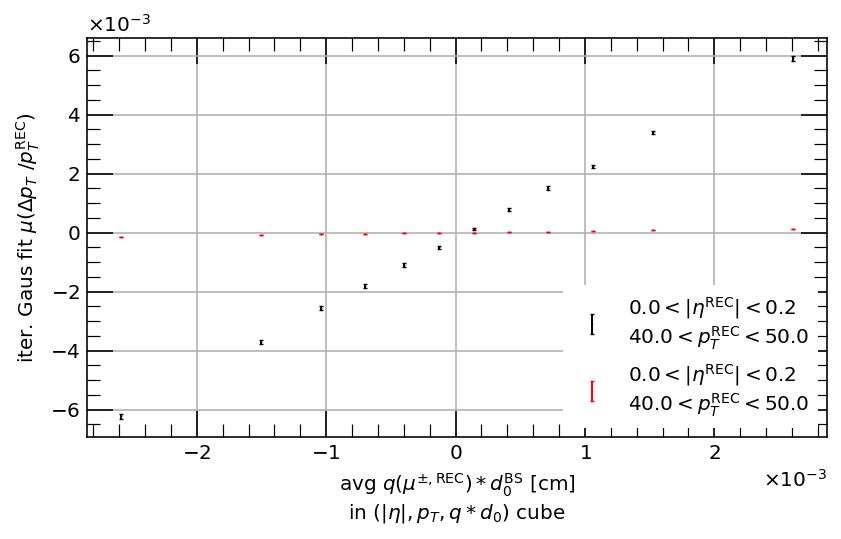

In [6]:
%config InlineBackend.figure_format = 'retina'
fig, ax = plt.subplots()
line1.draw_graph(x_label="",
                 y_label="", 
                 title="", 
                 kbin_example=kinbin_ls[0], 
                 ax=ax, count=1,
                 scale_by_1divpT=False,
                 verbose=False)
line1.draw_graph(x_label="",
                 y_label="", 
                 title="", 
                 kbin_example=kinbin_ls[0], 
                 ax=ax, count=2,
                 scale_by_1divpT=True,
                 verbose=False)


plt.tight_layout()
# plt.savefig("/Users/Jake/Desktop/barrel_test02.pdf")

In [11]:
def prune_kinbin_ls(N):
    """Remove a KinBin3D from main list if it has fewer than N entries."""
    
    return [kb for kb in kinbin_ls if kb.n_entries > N]

prune_kinbin_ls(3000)

NameError: name 'kinbin_ls' is not defined

In [1]:
import sys
sys.path.append('/Users/Jake/HiggsMassMeasurement/')
sys.path.append('/Users/Jake/HiggsMassMeasurement/d0_Studies/')
import numpy as np
import vaex
from vaex_Utils.vaex_dataframes import vdf_MC_2017_DY, vdf_MC_2017_Jpsi, vaex_apply_masks, prepare_vaex_df

vdf_concat_MC_2017_DY = prepare_vaex_df(vdf_MC_2017_DY)
vdf_concat_MC_2017_Jpsi = prepare_vaex_df(vdf_MC_2017_Jpsi)

[INFO] Successfully retrieved vdf_concat!
[INFO] vdf_concat has the following columns:
['massZ', 'massZErr', 'weight', 'GENmass2l', 'nFSRPhotons', 'pT', 'eta', 'phi', 'm', 'd0BS', 'd0PV', 'Id', 'pterr', 'genLep_pt', 'genLep_eta', 'genLep_phi', 'delta_eta', 'delta_phi', 'delta_R', 'delta_pT', 'delta_pToverGenpT', 'delta_pToverRecpT', 'delta_pToverGenpTsqred', 'delta_pToverRecpTsqred', 'qd0BS', 'qd0PV', 'index']

[INFO] Successfully retrieved vdf_concat!
[INFO] vdf_concat has the following columns:
['massZ', 'massZErr', 'weight', 'GENmass2l', 'nFSRPhotons', 'pT', 'eta', 'phi', 'm', 'd0BS', 'd0PV', 'Id', 'pterr', 'genLep_pt', 'genLep_eta', 'genLep_phi', 'delta_eta', 'delta_phi', 'delta_R', 'delta_pT', 'delta_pToverGenpT', 'delta_pToverRecpT', 'delta_pToverGenpTsqred', 'delta_pToverRecpTsqred', 'qd0BS', 'qd0PV', 'index']



In [2]:
# Unpack kinematic arrays for cuts.
eta_arr_DY = vdf_concat_MC_2017_DY.evaluate("eta")
pT_arr_DY = vdf_concat_MC_2017_DY.evaluate("pT")
qd0_arr_DY = vdf_concat_MC_2017_DY.evaluate("qd0BS")
massZ_arr_DY = vdf_concat_MC_2017_DY.evaluate("massZ")
dR_arr_DY = vdf_concat_MC_2017_DY.evaluate("delta_R")

eta_arr_Jpsi = vdf_concat_MC_2017_Jpsi.evaluate("eta")
pT_arr_Jpsi = vdf_concat_MC_2017_Jpsi.evaluate("pT")
qd0_arr_Jpsi = vdf_concat_MC_2017_Jpsi.evaluate("qd0BS")
massZ_arr_Jpsi = vdf_concat_MC_2017_Jpsi.evaluate("massZ")
dR_arr_Jpsi = vdf_concat_MC_2017_Jpsi.evaluate("delta_R")

kinem_arr_DY = vdf_concat_MC_2017_DY.evaluate("delta_pToverGenpT")
kinem_arr_Jpsi = vdf_concat_MC_2017_Jpsi.evaluate("delta_pToverGenpT")

# Cut limits.
eta_min = 1.4
eta_max = 1.6
pT_min = 30.0
pT_max = 40.0
qd0_min = -0.014915707521140575
qd0_max = -0.0011893846094608307
massZ_min_Jpsi = 2.9
massZ_max_Jpsi = 3.3
dR_max = 0.008

# Prepare masks.
mask_eta_DY = (eta_min < np.abs(eta_arr_DY)) & (np.abs(eta_arr_DY) < eta_max)
mask_pT_DY = (pT_min < pT_arr_DY) & (pT_arr_DY < pT_max)
mask_qd0_DY = (qd0_min < qd0_arr_DY) & (qd0_arr_DY < qd0_max)
mask_massZ_DY = (massZ_min_DY < massZ_arr_DY) & (massZ_arr_DY < massZ_max_DY)
mask_dR_DY = (dR_arr_DY < dR_max)

mask_eta_Jpsi = (eta_min < np.abs(eta_arr_Jpsi)) & (np.abs(eta_arr_Jpsi) < eta_max)
mask_pT_Jpsi = (pT_min < pT_arr_Jpsi) & (pT_arr_Jpsi < pT_max)
mask_qd0_Jpsi = (qd0_min < qd0_arr_Jpsi) & (qd0_arr_Jpsi < qd0_max)
mask_massZ_Jpsi = (massZ_min_Jpsi < massZ_arr_Jpsi) & (massZ_arr_Jpsi < massZ_max_Jpsi)
mask_dR_Jpsi = (dR_arr_Jpsi < dR_max)

all_masks_DY = mask_eta_DY & mask_pT_DY & mask_qd0_DY & mask_massZ_DY & mask_dR_DY
all_masks_Jpsi = mask_eta_Jpsi & mask_pT_Jpsi & mask_qd0_Jpsi & mask_massZ_Jpsi & mask_dR_Jpsi

selected_muons_Jpsi = kinem_arr_Jpsi[all_masks_Jpsi]
selected_muons_DY = kinem_arr_DY[all_masks_DY]

108

In [4]:
# Cut limits.
eta_min = 1.4
eta_max = 1.6
pT_min = 30.0
pT_max = 40.0
qd0_min = -0.014915707521140575
qd0_max = -0.0011893846094608307
massZ_min_DY = 60.0
massZ_max_DY = 120.0
dR_max = 0.008

184340

In [2]:
###### both:
eta_range = [1.4, 1.6]
pT_range = [30.0, 40.0] 
massZ_minmax_DY = [60, 120]
massZ_minmax_Jpsi = [2.9, 3.3]
dR_max = 0.008

kinem = "delta_pToverGenpT"

for qd0_limits in [
    [-0.014915707521140575, -0.0011893846094608307], 
    [-0.0011893846094608307, -0.0003716889477800578], 
    [-0.0003716889477800578, 0.00030780554516240954], 
    [0.00030780554516240954, 0.0011191896628588438], 
    [0.0011191896628588438, 0.014590197242796421]
]:
    try:
        del vdf_concat_MC_2017_DY
        del vdf_concat_MC_2017_Jpsi
    except NameError: 
        pass
    
    vdf_concat_MC_2017_DY = prepare_vaex_df(vdf_MC_2017_DY)
    vdf_concat_MC_2017_Jpsi = prepare_vaex_df(vdf_MC_2017_Jpsi)
    
    all_masks_DY = vaex_apply_masks(  vdf_concat_MC_2017_DY,       eta_range, pT_range, qd0_limits, massZ_minmax_DY,    dR_max)
    all_masks_Jpsi = vaex_apply_masks(  vdf_concat_MC_2017_Jpsi,   eta_range, pT_range, qd0_limits, massZ_minmax_Jpsi,   dR_max)

    selection_DY_arr = vdf_concat_MC_2017_DY.evaluate(kinem,selection=all_masks_DY)
    selection_Jpsi_arr = vdf_concat_MC_2017_Jpsi.evaluate(kinem,selection=all_masks_Jpsi)
    print("DY selected",len(selection_DY_arr))
    print("Jpsi selected",len(selection_Jpsi_arr))
    print("sum:", len(selection_DY_arr) + len(selection_Jpsi_arr), "\n")

[INFO] Successfully retrieved vdf_concat!
[INFO] vdf_concat has the following columns:
['massZ', 'massZErr', 'weight', 'GENmass2l', 'nFSRPhotons', 'pT', 'eta', 'phi', 'm', 'd0BS', 'd0PV', 'Id', 'pterr', 'genLep_pt', 'genLep_eta', 'genLep_phi', 'delta_eta', 'delta_phi', 'delta_R', 'delta_pT', 'delta_pToverGenpT', 'delta_pToverRecpT', 'delta_pToverGenpTsqred', 'delta_pToverRecpTsqred', 'qd0BS', 'qd0PV', 'index']

[INFO] Successfully retrieved vdf_concat!
[INFO] vdf_concat has the following columns:
['massZ', 'massZErr', 'weight', 'GENmass2l', 'nFSRPhotons', 'pT', 'eta', 'phi', 'm', 'd0BS', 'd0PV', 'Id', 'pterr', 'genLep_pt', 'genLep_eta', 'genLep_phi', 'delta_eta', 'delta_phi', 'delta_R', 'delta_pT', 'delta_pToverGenpT', 'delta_pToverRecpT', 'delta_pToverGenpTsqred', 'delta_pToverRecpTsqred', 'qd0BS', 'qd0PV', 'index']

Applying the following cuts to the VDF:
1.4 < vdf["eta"].abs()) & (vdf["eta"].abs() < 1.6)
30.0 < vdf["pT"]) & (vdf["pT"] < 40.0)
-0.014915707521140575 < vdf["qd0BS"]) & 

In [19]:
###### DY:
eta_range = [1.4, 1.6]
pT_range = [30.0, 40.0]
qd0_limits = [-0.014915707521140575, -0.0011893846094608307]
massZ_minmax_DY = [60, 120]
dR_max = 0.008

all_masks_DY = vaex_apply_masks(  vdf_concat_MC_2017_DY,   eta_range, pT_range, qd0_limits, massZ_minmax_DY,   dR_max)

kinem = "qd0BS"

selection_DY_arr = vdf_concat_MC_2017_DY.evaluate(kinem,selection=all_masks_DY)

np.shape(selection_DY_arr)[0]

Inside vaex_apply_masks:
eta_minmax list, [1.4, 1.6]
pT_minmax list, [30.0, 40.0]
qd0_minmax list, [-0.014915707521140575, -0.0011893846094608307]
massZ_minmax list, [60, 120]
dR_max, 0.008
masks obtained using:
eta_minmax[0],eta_minmax[1] 1.4 1.6
pT_minmax[0],pT_minmax[1] 30.0 40.0
qd0_minmax[0],qd0_minmax[1] -0.014915707521140575 -0.0011893846094608307
massZ_minmax[0],massZ_minmax[1] 60 120


184340

In [17]:
###### Jpsi:
eta_range = [1.4, 1.6]
pT_range = [30.0, 40.0]
qd0_limits = [-0.014915707521140575, -0.0011893846094608307]
massZ_minmax_DY = [60, 120]
massZ_minmax_DY = [60, 120]
massZ_minmax_Jpsi = [2.9, 3.3]
dR_max = 0.008

all_masks_Jpsi = vaex_apply_masks(  vdf_concat_MC_2017_Jpsi,   eta_range, pT_range, qd0_limits, massZ_minmax_Jpsi,   dR_max)

kinem = "delta_pToverGenpT"

selection_Jpsi_arr = vdf_concat_MC_2017_Jpsi.evaluate(kinem,selection=all_masks_Jpsi)

len(selection_Jpsi_arr)

Inside vaex_apply_masks:
eta_minmax list, [1.4, 1.6]
pT_minmax list, [30.0, 40.0]
qd0_minmax list, [-0.014915707521140575, -0.0011893846094608307]
massZ_minmax list, [2.9, 3.3]
dR_max, 0.008
masks obtained using:
eta_minmax[0],eta_minmax[1] 1.4 1.6
pT_minmax[0],pT_minmax[1] 30.0 40.0
qd0_minmax[0],qd0_minmax[1] -0.014915707521140575 -0.0011893846094608307
massZ_minmax[0],massZ_minmax[1] 2.9 3.3


108

In [18]:
###### Jpsi:
eta_range = [1.4, 1.6]
pT_range = [30.0, 40.0]
qd0_limits = [-0.014915707521140575, -0.0011893846094608307]
massZ_minmax_DY = [60, 120]
massZ_minmax_DY = [60, 120]
massZ_minmax_Jpsi = [2.9, 3.3]
dR_max = 0.008

all_masks_Jpsi = vaex_apply_masks(  vdf_concat_MC_2017_Jpsi,   eta_range, pT_range, qd0_limits, massZ_minmax_Jpsi,   dR_max)

kinem = "qd0BS"

selection_Jpsi_arr = vdf_concat_MC_2017_Jpsi.evaluate(kinem,selection=all_masks_Jpsi)

len(selection_Jpsi_arr)

Inside vaex_apply_masks:
eta_minmax list, [1.4, 1.6]
pT_minmax list, [30.0, 40.0]
qd0_minmax list, [-0.014915707521140575, -0.0011893846094608307]
massZ_minmax list, [2.9, 3.3]
dR_max, 0.008
masks obtained using:
eta_minmax[0],eta_minmax[1] 1.4 1.6
pT_minmax[0],pT_minmax[1] 30.0 40.0
qd0_minmax[0],qd0_minmax[1] -0.014915707521140575 -0.0011893846094608307
massZ_minmax[0],massZ_minmax[1] 2.9 3.3


108

In [ ]:
### Making delicious selections.

d0_type = "BS"
p_str_latex = "$p_{T}$"
x_lim_eta = [0.0, 0.2]
x_lim_pT = [5, 10]

# bins_eta = [-2.4, 2.4, 0.1]
# bins_pT = [5, 10, 0.1]
bins_qd0 = [0.000, 0.001, 0.00002]
dR_cut = 0.008
massZ_ls = [60, 120]

eta_min = x_lim_eta[0]
eta_max = x_lim_eta[1]
pT_min = x_lim_pT[0]
pT_max = x_lim_pT[1]
qd0_min = bins_qd0[0]
qd0_max = bins_qd0[1]
massZ_min = massZ_ls[0]
massZ_max = massZ_ls[1]


kinem = "qd0BS"
# Selections.
mask_eta = (eta_min < vdf_concat["eta"]) & (vdf_concat["eta"] < eta_max)
mask_pT = (pT_min < vdf_concat["pT"]) & (vdf_concat["pT"] < pT_max)
mask_qd0 = (qd0_min < vdf_concat["qd0BS"]) & (vdf_concat["qd0BS"] < qd0_max)
mask_massZ = (60 < vdf_concat["massZ"]) & (vdf_concat["massZ"] < 120)
mask_dR = (vdf_concat["delta_R"] < 0.008)

all_masks = mask_pT & mask_eta & mask_qd0 & mask_massZ & mask_dR

# vdf_concat.plot1d(vdf_concat["pT"], 
#                   limits=[-2, 15],
#                   selection=selec, 
#                   marker="",
#                   ylabel="Events",
#                  figsize=(12.8, 9.6))

if kinem == "qd0BS":
    x_bin_limits = bins_qd0
    x_range = [bins_qd0[0], bins_qd0[1]]
elif kinem == "pT":
    x_bin_limits = bins_pT
    x_range = [bins_pT[0], bins_pT[1]]
elif kinem == "eta":
    x_bin_limits = bins_eta
    x_range = [bins_eta[0], bins_eta[1]]

x_bins, binwidth = make_binning_array(x_bin_limits)

x_label = label_LaTeX_dict[kinem + '1']["independent_label"]
x_units = label_LaTeX_dict[kinem + '1']["units"]
y_label = hist_y_label(binwidth, x_units)
if len(x_units) > 0:
    x_label += " [{}]".format(x_units)

    
title  = "Selection:\n"
title += r"$\Delta R < %.3f$,  " % (dR_cut)
title += r"$%.1f < m_{\mu\mu} < %.1f$ GeV" % (massZ_min, massZ_max) + "\n"
title += r"$%.3f < q(\mu)*d_{0}^{\mathrm{%s}} < %.3f$,  " % (qd0_min, d0_type, qd0_max)
title += r"$%d <$ %s $< %d$ GeV,  " % (pT_min, p_str_latex, pT_max) 
title += r"$%.2f < \left| \eta^{\mathrm{REC}} \right| < %.2f$" % (eta_min, eta_max)


# f, ax = plt.subplots(figsize=(12.8, 9.6))
f, ax = plt.subplots()
ax, bin_vals, bin_edges, stats = make_1D_dist(ax, 
                                              vdf_concat.evaluate(kinem, selection=all_masks), 
                                              x_range,
                                              x_bins, 
                                             x_label=x_label, 
                                             y_label=y_label,
                                             title=title,
                                             y_max=-1,
                                            log_scale=False)

In [2]:
import os

In [5]:
os.path.split("/Users/Jake/Desktop/Research/Higgs_Mass_Measurement/d0_studies/hists_dpToverpT/MC/2017/stats.txt")[1]

'stats.txt'

In [4]:
# Works with the original VDF, just after reading from hdf5.
# Takes a long time though, because we are saving a vdf to an object. 

#--------------------------------------#
#--- Save and manipulate variables. ---#
#--------------------------------------#
# GEN info. 
eta1_gen_ser = vdf_mod['genLep_eta1']  # Good!
eta2_gen_ser = vdf_mod['genLep_eta2']  # Good!
phi1_gen_ser = vdf_mod['genLep_phi1']  # Good!
phi2_gen_ser = vdf_mod['genLep_phi2']  # Good!
pT1_gen_ser  = vdf_mod['genLep_pt1']  # Good!
pT2_gen_ser  = vdf_mod['genLep_pt2']  # Good!

# RECO info.
eta1_rec_ser = vdf_mod['eta1']  # Good!
eta2_rec_ser = vdf_mod['eta2']  # Good!
phi1_rec_ser = vdf_mod['phi1']  # Good!
phi2_rec_ser = vdf_mod['phi2']  # Good!
pT1_rec_ser  = vdf_mod['pT1']  # Good!
pT2_rec_ser  = vdf_mod['pT2']  # Good!

# Store other variables.
vdf_mod['delta_eta1'] = deta1_ser = eta1_rec_ser - eta1_gen_ser  # Good!
vdf_mod['delta_eta2'] = deta2_ser = eta2_rec_ser - eta2_gen_ser  # Good!
# Remember that delta_phi requires special treatment:
# -pi < delta_phi < pi
vdf_mod['delta_phi1'] = dphi1_ser = vdf_mod.apply(calc_dphi, (phi1_rec_ser, phi1_gen_ser))  # Good!
vdf_mod['delta_phi2'] = dphi2_ser = vdf_mod.apply(calc_dphi, (phi2_rec_ser, phi2_gen_ser))  # Good!
vdf_mod['delta_R1'] = dR1_ser = vdf_mod.apply(calc_dR, (deta1_ser, dphi1_ser))
vdf_mod['delta_R2'] = dR2_ser = vdf_mod.apply(calc_dR, (deta2_ser, dphi2_ser))
vdf_mod['delta_pT1'] = dpT1 = pT1_rec_ser - pT1_gen_ser  # Good!
vdf_mod['delta_pT2'] = dpT2 = pT2_rec_ser - pT2_gen_ser  # Good!
vdf_mod['delta_pToverGenpT1'] = dpTratioGen1 = dpT1 / pT1_gen_ser  # Good!
vdf_mod['delta_pToverGenpT2'] = dpTratioGen2 = dpT2 / pT2_gen_ser  # Good!
vdf_mod['delta_pToverRecpT1'] = dpTratioRec1 = dpT1 / pT1_rec_ser  # Good!
vdf_mod['delta_pToverRecpT2'] = dpTratioRec2 = dpT2 / pT2_rec_ser  # Good!  
vdf_mod['delta_pToverGenpTsqred1'] = dpTratioGen1 / pT1_gen_ser  # Good! 
vdf_mod['delta_pToverGenpTsqred2'] = dpTratioGen2 / pT2_gen_ser  # Good!  
vdf_mod['delta_pToverRecpTsqred1'] = dpTratioRec1 / pT1_rec_ser  # Good!  
vdf_mod['delta_pToverRecpTsqred2'] = dpTratioRec2 / pT2_rec_ser  # Good! 
vdf_mod['qd0BS1'] = vdf_mod['d0BS1'] * vdf_mod['Id1'] / -13.  # Good!
vdf_mod['qd0BS2'] = vdf_mod['d0BS2'] * vdf_mod['Id2'] / -13.  # Good!
vdf_mod['qd0PV1'] = vdf_mod['d0PV1'] * vdf_mod['Id1'] / -13.  # Good!
vdf_mod['qd0PV2'] = vdf_mod['d0PV2'] * vdf_mod['Id2'] / -13.  # Good!

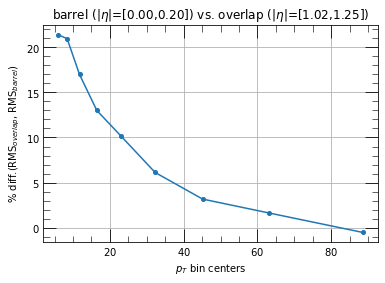

In [30]:
import matplotlib.pyplot as plt
%matplotlib inline
ptbins = [5,
7,
9.8,
13.7,
19.2,
26.9,
37.6,
52.7,
73.8,
103.3]

rms_perc_diff = [21.41,
20.97,
17.00,
13.00,
10.14,
6.12,
3.16,
1.61,
-0.54]

centers = centers_of_binning_array(np.array(ptbins))

plt.style.use("cmsstyle_plot")
f, ax = plt.subplots()
ax.plot(centers, rms_perc_diff)
ax.set_xlabel(r"$p_T$ bin centers")
ax.set_ylabel(r"% diff.(RMS$_{overlap}$, RMS$_{barrel}$)")
ax.set_title(r"barrel ($\left| \eta \right|$=[0.00,0.20]) vs. overlap ($\left| \eta \right|$=[1.02,1.25])")

plt.savefig("/Users/Jake/Desktop/RMS_perc_diff.pdf", dpi=600)

## DY vs. DY+$J/\psi$ stats:

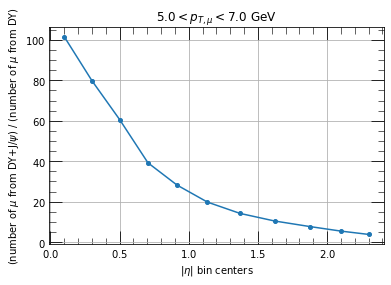

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline
etabins = [0,
0.2,
0.40,
0.60,
0.81,
1.02,
1.25,
1.49,
1.75,
2.00,
2.20,
2.40]

# DY+J/psi muons / DY muons
y_vals = [
101.5120551,
79.79403541,
60.6124498,
39.21210782,
28.22580645,
19.80656629,
14.23404255,
10.47976144,
7.727619196,
5.479657028,
3.845729617,
]

x_vals = centers_of_binning_array(np.array(etabins))

plt.style.use("cmsstyle_plot")
f, ax = plt.subplots()
ax.plot(x_vals, y_vals)
ax.set_xlabel(r"$\left| \eta \right|$ bin centers")
# ax.set_ylabel(r"$\frac{\mathrm{number}\; \mu \mathrm{from\; DY + J/}\psi}{\mathrm{number} \mu \mathrm{from DY}}$")
ax.set_ylabel(r"(number of $\mu$ from DY+J/$\psi$) / (number of $\mu$ from DY)")
ax.set_title(r"$5.0 < p_{T, \mu} < 7.0$ GeV")

plt.savefig("/Users/Jake/Desktop/num_muons_DYJpsi_vs_DY__MC2017.pdf", dpi=600)

In [177]:
# I attempted to make it work with vaex. It almost works!

class KinematicBinVaex():

    def __init__(self, 
                vaex_df, 
#                  inpath_dataframe, 
                 n_evts, 
                 massZ_cut_ls, eta_cut_ls, pT_cut_ls, qd0_cut_ls, d0_type="BS", dR_cut=0.02, 
                 use_ptotal_instead=False, verbose=False):
        """
        Pass in a DataFrame (DF) and specify the eta and pT cuts to create a subset of DF.
        
        Parameters
        ----------
        vaex_df : pandas.DataFrame
            ROOT file converted into a DataFrame. Columns are branches. Rows are events.
        n_evts : int
            Number of events to search over - not guaranteed to find this many events! 
            Use '-1' to loop over all events in the df. 
        eta_cut_ls : list or array-like of floats
            A list of [eta_min, eta_max]. Example: [0.9, 1.8]
        pT_cut_ls : list or array-like of floats
            A list of [pT_min, pT_max]. Example: [5, 20]
        qd0_cut_ls : list or array-like of floats
            A list of values of d0*charge to cut on: [qd0_min, qd0_max]. E.g. [-0.01, 0.01]
        d0_type : str
            Which d0 to cut on: "BS" or "PV"
        use_ptotal_instead : bool
            Cut on total momentum instead of pT. 
            In most places, pT could stand for either p or pT (depending on 'use_ptotal_instead').
                Just be careful because not all places are adapted for p!
        dR_cut : float
            A cut to save events in which muon1 and muon2 both have dR < dR_cut.
        verbose : bool
            If True, get debug info and see where you are while the code runs.
            
        NOTE:
            The methods further down are more developed than the methods closer to __init__(). 
            Therefore, clean up and consolidate the earlier methods. 
        """
        if n_evts == -1:
            n_evts = len(vaex_df)
        df = vaex_df[:n_evts]    # Original DF. 
        print("length of df:",len(df))
        self.n_evts_asked_for = n_evts
        self.n_evts_found = -999
        self.kinem_vals_after_selection = {}
        self.stats_dict = {}
        self.verbose = verbose
        
        self.cuts = ""
        self.sorted_cut_ls = []
        self.cut_dict = {}
        self.use_ptotal_instead = use_ptotal_instead
        self.p_str = "p" if (self.use_ptotal_instead) else "pT"
        self.p_str_latex = r"$p^{\mathrm{REC}}$" if (self.use_ptotal_instead) else r"$p_{T}^{\mathrm{REC}}$"

        self.massZ_min = massZ_cut_ls[0]
        self.massZ_max = massZ_cut_ls[1]        
        self.eta_min   = eta_cut_ls[0]
        self.eta_max   = eta_cut_ls[1]
        self.pT_min    = pT_cut_ls[0] 
        self.pT_max    = pT_cut_ls[1]         
        self.qd0_min   = qd0_cut_ls[0]
        self.qd0_max   = qd0_cut_ls[1]
        self.d0_type   = d0_type
        self.dR_cut    = dR_cut   
                
        self.apply_initial_cuts(df, verbose)
        
    def apply_initial_cuts(self, df, verbose):
        """
        Creates a subset of the original DataFrame in which initial cuts are applied.
        Cuts:
            pT
            eta
            q*d0
            massZ
            dR
        """
# VDF is good up to here at least.
        # Cuts:
        
        
        print("Show1:", df.column_names)
        # Create masks.
        print("Getting mask massZ...") 
        self.mask_massZ = mask_massZ = self.get_mask_massZ(df)
        print("Getting mask eta...")
        self.mask_eta1, self.mask_eta2 = mask_eta1, mask_eta2 = self.get_mask_eta(df)
        print("Getting mask pT...")
        self.mask_pT1,  self.mask_pT2  = mask_pT1,  mask_pT2  = self.get_mask_pT(df)
        print("Getting mask qd0...")
        self.mask_qd01, self.mask_qd02 = mask_qd01, mask_qd02 = self.get_mask_qd0(df)    
        print("Getting mask dR...")
        self.mask_dR1,  self.mask_dR2  = mask_dR1,  mask_dR2  = self.get_mask_dR(df) 
        
        # Combine masks.
        print("Individual masks...")
        self.mask_kinembin_lep1 = mask_massZ & mask_dR1 & mask_eta1 & mask_pT1 & mask_qd01
        self.mask_kinembin_lep2 = mask_massZ & mask_dR2 & mask_eta2 & mask_pT2 & mask_qd02

        # Keep all events in which either muon1 passed all selections or muon2 passed all. 
        print("Combining masks...")
        self.all_masks = self.mask_kinembin_lep1 | self.mask_kinembin_lep2
        print("Applying all masks...")
        # Apply masks and update DataFrame.
#         self.binned_df = df[self.all_masks]
        df_cuts_applied = df.select(self.all_masks)
        print("vdf attached to object")
        self.n_evts_found = len(df_cuts_applied)
        print("empty fucker")
        # The cut_dict has been filled. Now convert it to an ordered list (alphabetically).
        self.sorted_cut_ls = sorted_cut_ls = [value for (key, value) in sorted(self.cut_dict.items())]
        self.cuts = combine_cut_list(sorted_cut_ls)
        
        if (self.verbose): 
            perc = self.n_evts_found / float(self.n_evts_asked_for) * 100.
            print("[INFO] Events found: {} ({:.3f}% of total events scanned)".format(self.n_evts_found, perc))
            print(r"using cuts: {}".format(self.cuts) + "\n")
      
    def get_mask_qd0(self, df):
        d0_type = self.d0_type
        if d0_type == "PV":
            mask_qd01 = (self.qd0_min < df['qd0PV1']) & (df['qd0PV1'] < self.qd0_max)
            mask_qd02 = (self.qd0_min < df['qd0PV2']) & (df['qd0PV2'] < self.qd0_max)
        elif d0_type == "BS":
            mask_qd01 = (self.qd0_min < df['qd0BS1']) & (df['qd0BS1'] < self.qd0_max)
            mask_qd02 = (self.qd0_min < df['qd0BS2']) & (df['qd0BS2'] < self.qd0_max)
            
        cuts_qd0 = r"$%.3f < q(\mu)*d_{0}^{\mathrm{%s}} < %.3f$" % (self.qd0_min, self.d0_type, self.qd0_max)
        key = "qd0{}".format(self.d0_type)
        self.cut_dict[key] = cuts_qd0
        print("mask_qd01:", mask_qd01.sum())
        print("mask_qd02:", mask_qd02.sum())
        return mask_qd01, mask_qd02
 
    def get_mask_pT(self, df):
        if (self.use_ptotal_instead):
            mask_pT1 = (self.pT_min < df['p1']) & (df['p1'] < self.pT_max) 
            mask_pT2 = (self.pT_min < df['p2']) & (df['p2'] < self.pT_max)
        else:
            mask_pT1 = (self.pT_min < df['pT1']) & (df['pT1'] < self.pT_max) 
            mask_pT2 = (self.pT_min < df['pT2']) & (df['pT2'] < self.pT_max)
        
        cuts_p = r"$%d <$ %s $< %d$ GeV" % (self.pT_min, self.p_str_latex, self.pT_max)  # The string brings in its own '$'.
        self.cut_dict[self.p_str] = cuts_p
        print("mask_pT1:", mask_pT1.sum())
        print("mask_pT2:", mask_pT2.sum())
        return mask_pT1, mask_pT2

    def get_mask_eta(self, df):
        mask_eta1 = (self.eta_min < abs(df['eta1'])) & (abs(df['eta1']) < self.eta_max)
        mask_eta2 = (self.eta_min < abs(df['eta2'])) & (abs(df['eta2']) < self.eta_max)   
        
        cuts_eta = r"$%.2f < \left| \eta^{\mathrm{REC}} \right| < %.2f$" % (self.eta_min, self.eta_max)
        self.cut_dict["eta"] = cuts_eta
        print("mask_eta1:", mask_eta1.sum())
        print("mask_eta2:", mask_eta2.sum())
        return mask_eta1, mask_eta2

    def get_mask_dR(self, df):
        print("df['delta_R1']:", df['delta_R1'][:30])
        print("df['delta_R2']:", df['delta_R2'][:30])
        print("self.dR_cut:", self.dR_cut)
        mask_dR1 = (df['delta_R1'] < self.dR_cut)
        mask_dR2 = (df['delta_R2'] < self.dR_cut)
        
        cuts_dR = r"$\Delta R < %.3f$" % (self.dR_cut)
        self.cut_dict["delta_R"] = cuts_dR
        print("mask_dR1:", mask_dR1.sum())
        print("mask_dR2:", mask_dR2.sum())
        return mask_dR1, mask_dR2
    
    def get_mask_massZ(self, df):
        mask_massZ = (self.massZ_min < df['massZ']) & (df['massZ'] < self.massZ_max)
        
        cuts_massZ = r"$%.1f < m_{\mu\mu} < %.1f$ GeV" % (self.massZ_min, self.massZ_max)
        self.cut_dict["massZ"] = cuts_massZ
        print("mask_massZ:", mask_massZ.sum())
        return mask_massZ    
    
    def apply_mask_get_data(self, df, kinem, lep_selection_type="", weave=False):
        """
        Return the kinematic values of the certain leptons by grouping them in different ways. 
            
            lep_selection_type = "1" -- get kinem values in which muon1 passes all selection criteria 
                                       (muon 2 may or may not pass selections).
            lep_selection_type = "2" -- get kinem values in which muon2 passes all selection criteria.
            lep_selection_type = "both" -- BOTH muons must pass selections to get data from event.
            lep_selection_type = "either" -- Either muon1, or muon2, or both must pass selections to get data from event.
            lep_selection_type = "independent" -- Get kinematic values for muon1 and muon2, with no restriction on which event they came from.
                Note: If kinem ends in "1" or "2", then the kinematic values of the other lepton are automatically grabbed.
                
        E.g. Apply a boolean mask for event selection and retrieve all "delta_R1" values.

        Parameters
        ----------
        df : vaex DataFrame
            DF with cuts already applied (massZ, pT, etc.).
        kinem : str
            A complete branch name in the DataFrame or root file. 
                E.g. "pT1", "genLep_pt2", "massZ"
        lep_selection_type : int
            The lepton's mask you want to apply.
        weave : bool
            Weave lep1 kinematic values and lep2 kinematic values together, so that slicing doesn't just give lep1. 
            Only relevant for "independent" selection.
        
        Returns
        -------
        kinem_vals : array 
            Kinematic values with chosen mask applied. 
            All values satisfy selection criteria for this kinematic bin.
        """
        mask1 = self.mask_kinembin_lep1
        mask2 = self.mask_kinembin_lep2
        
        if lep_selection_type == "1":
            # Only select events in which muon1 passes selections.
            mask = mask1
        elif lep_selection_type == "2":
            # Only select events in which muon2 passes selections.
            mask = mask2
        elif lep_selection_type == "both":
            # Only select events in which BOTH muon1 and muon2 pass selections.
            mask = mask1 & mask2
        elif lep_selection_type == "either":
            # Only select events in which BOTH muon1 and muon2 pass selections.
            mask = mask1 | mask2
        elif lep_selection_type == "independent":
            # Go through all muons in all events, without regard for other muon. 
            if kinem[-1] in ["1", "2"]:
                # Lep1 (or lep2) kinematic detected. Go find the other lepton's kinematic values.
                # FIXME: the variable massZ_vtxChi2 will be wrongly caught by this 'if' statement!
                kinem1 = kinem[:-1] + "1"
                kinem2 = kinem[:-1] + "2"
                kinem_vals1 = df[kinem1][mask1].values
                kinem_vals2 = df[kinem2][mask2].values
            else:
                # The kinematic doesn't depend on lep1 or lep2, like: massZ, GENmass2l, etc.
                kinem_vals1 = df[kinem][mask1].values
                kinem_vals2 = df[kinem][mask2].values
            
            if (weave):
                # Weave values together so that when slicing (like [:5]), you don't just grab kinem_vals1. 
                kinem_vals = np.array( weave_lists(kinem_vals1, kinem_vals2) )
            else: 
                kinem_vals = np.append(kinem_vals1, kinem_vals2)
        
            return kinem_vals
        
        else: 
            raise ValueError("[ERROR] `lep_selection_type` was not specified properly. Stopping now.")
        
        # A selection, other than "independent" was chosen.
        kinem_vals = df[kinem][mask].values
        
        return kinem_vals
    
    def make_2D_plot(self, 
                     df, 
                     x_kinem, y_kinem, 
                     x_bin_limits=[0, 1, 0.1], y_bin_limits=[0, 1, 0.1],
                     lep_selection_type="",
                     run_over_only_n_evts=-1, 
                     title="",
                     exclusive=True,
                     save_plot=False, save_as_png=False, outpath="",
                     ax=None):
        """
        Make a 2D plot. Two examples:
            (1) dphi vs. deta  
            (2) dphi vs. dtheta
        User can specify the binning along either axis. 
        This method plots only the muons which pass the selection 
        (as opposed to taking any event in which at least 1 muon pass kinematic bin criteria).
        
        Parameters
        ----------
        x_kinem : str
            The PARTIAL name of the kinematical variable to be plotted along x-axis. 
            Only works for kinematics which end with '1' or '2'.
            - Example: x_kinem="delta_theta" (for which there are two branches: "delta_theta1", "delta_theta2")
        y_kinem : str
            The PARTIAL name of the kinematical variable to be plotted along y-axis. 
            Only works for kinematics which end with '1' or '2'.
            - Example: y_kinem="delta_eta" (for which there are two branches: "delta_eta1", "delta_eta2")
        x_bin_limits : list or array-like of floats
            The bin limits on the horizontal axis. [bin_min_left_edge, bin_max_right_edge, bin_width]
            - Example: [-2.5, 2.5, 0.1]
        y_bin_limits : list or array-like of floats
            The bin limits on the vertical axis. [bin_min_left_edge, bin_max_right_edge, bin_width]
            - Example: [-2.5, 2.5, 0.1]
        lep_selection_type : str
            What kind of selection to perform on the leptons. Choices:
            #UPDATE
        run_over_only_n_evts : int
            Number of events to plot. Use '-1' to use all events in this kinembin.
        title : str
            Alternate title to put on plot. Overrides the default one made in this method.
        exclusive : bool
            Means "only put muons which passed all selections in this plot".
            FIXME: It must be set to True for now...
        save_plot : bool
            If True, save the plot as a pdf and possibly a png.
        save_as_png : bool
            If True, save the plot as a png.
        outpath : str
            Path to save plot.
        """           
        x_kinem1 = x_kinem + "1"
        x_kinem2 = x_kinem + "2"
        y_kinem1 = y_kinem + "1"
        y_kinem2 = y_kinem + "2"
        
        x_vals = self.apply_mask_get_data(x_kinem1, lep_selection_type=lep_selection_type, weave=True)
        y_vals = self.apply_mask_get_data(y_kinem2, lep_selection_type=lep_selection_type, weave=True)
        if run_over_only_n_evts != -1:
            x_vals = x_vals[:run_over_only_n_evts]
            y_vals = y_vals[:run_over_only_n_evts]

        # A special case to make comparison of (delta_phi vs. delta_theta) easy with (delta_phi vs. delta_eta).
        if (x_kinem1[:-1] == "delta_theta") and (y_kinem1[:-1] == "delta_phi"):
            x_vals *= -1

        #--- Make plots ---#
        if (ax is None):
            f, ax = plt.subplots(figsize=(12.8, 9.6))
        
        x_2D_bins, x_2D_bin_width = make_binning_array(x_bin_limits)
        y_2D_bins, y_2D_bin_width = make_binning_array(y_bin_limits) 
        
        # Plot 1: dphi vs. deta
        if lep_selection_type not in ["1","2"]:
            x_label = label_LaTeX_dict[x_kinem1]["independent_label"]
            y_label = label_LaTeX_dict[y_kinem1]["independent_label"]
        else:
            x_label_1 = label_LaTeX_dict[x_kinem1]["label"]
            x_label_2 = label_LaTeX_dict[x_kinem2]["label"]
            y_label_1 = label_LaTeX_dict[y_kinem1]["label"]
            y_label_2 = label_LaTeX_dict[y_kinem2]["label"]

            x_unit = label_LaTeX_dict[x_kinem2]["units"]
            y_unit = label_LaTeX_dict[y_kinem2]["units"]

            def prep_2D_label(label_1, label_2, unit, bin_width):
                label = "{},   {}".format(label_1, label_2)
                label += "\n" + "(bin width: {:.2E})".format(bin_width)
                if len(unit) > 0:
                    label =label.rstrip(")")
                    label += " {})".format(unit)  
                return label

            x_label = prep_2D_label(x_label_1, x_label_2, x_unit, x_2D_bin_width)
            y_label = prep_2D_label(y_label_1, y_label_2, y_unit, y_2D_bin_width)

        ax.set_xlabel(x_label)#, fontsize=label_size)
        ax.set_ylabel(y_label)#, fontsize=label_size)
        
        if len(title) > 0:
            title += "\n"
        cuts = "Selection type = {}:\n".format(lep_selection_type) 
        cuts += r"{}".format(self.cuts)
#         ax.set_title(title + cuts)#, fontsize=label_size)
    
        # Stats: 
#         stat_text_x = 0.1
        stat_text_x = 0.2
        stat_text_y = 0.83
        
        stats_ls = get_stats_2Dhist(x_vals, y_vals)
        leg_label = cuts + "\n" + make_stats_legend_for_2dhist(stats_ls)
        ax.text(stat_text_x, stat_text_y, leg_label, horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
        
        newcmp = change_cmap_bkg_to_white('rainbow')
        bin_vals, x_bin_edges, y_bin_edges, im = ax.hist2d(x_vals, y_vals, bins=[x_2D_bins, y_2D_bins], cmap=newcmp)
        plt.colorbar(im, ax=ax)

    def plot_kinem_genrec_comparison(self,
                              kinem_gen, kinem_rec, 
                              lep_selection_type="independent", 
                              x_limits=[-1, 1],
                              bin_limits=[-0.5,0.5,0.5], 
                              run_over_only_n_evts=-1,
                              ax=None, ax_ratio=None, log_scale=False
                              ):
            """
            FIXME: Need to implement under/overflow bins!

            Plots differences in kinematics. Includes a ratio plot at the bottom.
            
            Parameters
            ----------
            kinem_gen : str
                The generator-level kinematical variable from the column of DF.
                E.g. "genLep_pt1" or "genLep_eta2", etc.
            kinem_rec : str
                The reconsructed-level kinematical variable from the column of DF.
                E.g. "pT1" or "eta2", etc.
            x_limits : 2-element list
                The x_min and x_max to show along x_axis, for viewing purposes: [x_min, x_max]
            bin_limits : 3-element list
                [first_bin_left_edge, last_bin_right_edge, bin_width]
            ax : axes object
                An external axes object to pass in, on which the main plot will be plotted.
                If None, a default one will get created.
            ax_ratio : axes object
                An external axes object to pass in, on which the ratio plot will be plotted.
                If None, a default one will get created.
            log_scale : bool
                Set y-axis to log scale.
            """

            df = self.binned_df

            x_bin_arr, x_bin_width = make_binning_array(bin_limits)
            x_bin_centers_arr = shift_binning_array(x_bin_arr)

            #--- Get data ---#
            # Make sure you're plotting gen and rec of same lepton.
            if kinem_gen[-1] != kinem_rec[-1]:
                print("[WARNING] It seems you are plotting lepton 1 kinematics vs. lepton 2's!")
            if kinem_gen[-1] != lep_selection_type:
                err_msg = "[ERROR] You want to plot lep{} kinematics but you specified lep{} selection type.".format(kinem_gen[-1], lep_selection_type)
                raise ValueError(err_msg)

            # Chooses either lep1 or lep2. 
            data_rec = self.apply_mask_get_data(kinem_rec, lep_selection_type)
            data_gen = self.apply_mask_get_data(kinem_gen, lep_selection_type)

            if run_over_only_n_evts != -1:
                data_rec = data_rec[:run_over_only_n_evts]
                data_gen = data_gen[:run_over_only_n_evts]
                
            # Gen and Reco stats:
            stats_ls_gen = get_stats_1Dhist(data_gen)
            stats_ls_rec = get_stats_1Dhist(data_rec)

            #----------------#
            #--- Plot It. ---#
            #----------------#
            if (ax is None) or (ax_ratio is None):
                fig = plt.figure(figsize=(10,8))
                ax = fig.add_axes([0.17,0.33,0.825,0.54])  # [low_left_corner_x, low_left_corner_y, width, height]
                ax_ratio = fig.add_axes([0.17,0.12,0.825,0.20])

            leg_label_gen = make_stats_legend_for_1dhist(stats_ls_gen)
            leg_label_rec = make_stats_legend_for_1dhist(stats_ls_rec)

            leg_label_gen = leg_label_gen.replace("Entries", "GEN Entries")
            leg_label_rec = leg_label_rec.replace("Entries", "REC Entries")

            hist_bin_vals_gen, bin_edges_gen, _ = ax.hist(data_gen, bins=x_bin_arr, histtype='step', color='g', lw=2, label=leg_label_gen)
            hist_bin_vals_rec, bin_edges_rec, _ = ax.hist(data_rec, bins=x_bin_arr, histtype='step', color='b', label=leg_label_rec)

            hist_bin_vals_gen_modified = hist_bin_vals_gen.copy()
            hist_bin_vals_gen_modified[hist_bin_vals_gen == 0] = 0.0000000001
            ratio_vals = (hist_bin_vals_rec - hist_bin_vals_gen) / hist_bin_vals_gen_modified

            ax_ratio.errorbar(x_bin_centers_arr, ratio_vals, xerr=x_bin_width/2, color='black', ms=0, capsize=0, mew=0, ecolor='black', drawstyle='steps-mid', alpha=1)

            # Pretty up the plot. 
            ax_ratio.grid(which='major',axis='x')
            ax_ratio.grid(which='major',axis='y', ls='-')
            ax_ratio.grid(which='minor',axis='y')

            # Hide first tick label on y-axis, since it overlaps with ratio plot's tick label.
            a=ax.get_yticks().tolist()
            a[0]=''
            ax.set_yticklabels(a)

            # Hide main plot's x tick labels.
            plt.setp(ax.get_xticklabels(), visible=False)

            # Only show a few of the tick labels on ratio plot.
            n_tick_labels = 5
            ax_ratio.yaxis.set_major_locator(plt.MaxNLocator(n_tick_labels))
            ax_ratio.axhline(c='r', lw=2, ls='-')

            textsize_legend = 10
            textsize_axislabels = 12
            textsize_title = 12

            unit_gen = label_LaTeX_dict[kinem_gen]["units"]
            unit_rec = label_LaTeX_dict[kinem_rec]["units"]
            
            y_label = hist_y_label(x_bin_width, unit_gen)
            
            # Remember that ax shouldn't have an x-label; it's covered by the ax_ratio. 
            ax.set_ylabel(y_label, fontsize=textsize_axislabels)
#             ax.set_title(r"Selection: {}".format(self.cuts), fontsize=textsize_title)
            
            textbox_text = "Selection type = {}:\n".format(lep_selection_type) + self.cuts
            ax.text(0.025, 0.83, textbox_text, horizontalalignment='left', verticalalignment='center', transform=ax.transAxes)
        
            plt.minorticks_on()

            x_min = x_limits[0]
            x_max = x_limits[1]
            ax.set_xlim([x_min, x_max])
            ax_ratio.set_xlim([x_min, x_max])
            ax_ratio.set_ylim([-0.12, 0.12])

            x_label_gen = label_LaTeX_dict[kinem_gen]["label"]
            x_label_rec = label_LaTeX_dict[kinem_rec]["label"]
            
            x_label = r"{}, {}".format(x_label_gen, x_label_rec)
            if len(unit_gen) > 0:
                x_label += " [{}]".format(unit_gen)
            ax_ratio.set_xlabel(x_label, fontsize=textsize_axislabels)
            ax_ratio.set_ylabel(r'$\frac{ (\mathrm{REC} - \mathrm{GEN}) }{ \mathrm{GEN} }$', fontsize=textsize_axislabels*1.5)

            y_max = max(max(hist_bin_vals_gen), max(hist_bin_vals_rec))
            ax.set_ylim([0, y_max*1.4])

            ax.legend(loc='upper right', framealpha=0.9, fontsize=textsize_legend)#, horizontalalignment='right')
            
            return ax, ax_ratio

    def plot_1D_kinematics(self, kinem="", lep_selection_type="independent", x_limits=[0,0], bin_limits=[0,0,0], run_over_only_n_evts=-1, ax=None, x_label="", y_label="", title="", y_max=-1, log_scale=False, iter_gaus=(False, 0)):
        """
        Make a histogram of a kinematical variable in the DF.  
        FIXME: 
            - Currently only works with kinem variables that end with `1` or `2`. 
            [ ] Eventually plot other quantities like massZ, etc.
        
        Parameters
        ----------
        kinem : str
            The full name of the kinematical branch/column ("delta_eta1", "delta_R2", "massZ", etc.)
        lep_selection_type : int
            Indicates the kind of selection to apply on leptons:
                lep_selection_type = "1"    -- Plot kinem values in which only lepton1 passed selections.
                lep_selection_type = "2"    -- Plot kinem values in which only lepton2 passed selections.
                lep_selection_type = "both" -- Plot kinem values in which lepton1 AND lepton2 passed selections.
                lep_selection_type = "either" -- Plot kinem values in which lepton1 OR lepton2 passed selections.
        x_limits : 2-element list
            The x_min and x_max to show along x_axis, for viewing purposes: [x_min, x_max]
        bin_limits : 3-element list
            [first_bin_left_edge, last_bin_right_edge, bin_width]   
        run_over_only_n_evts : int
            Number of events to put into histogram. 
        ax : axes object
            An external axes object to pass in, on which the main plot will be plotted.
            If None, a default one will get created.
        x_label : str
            Override the default x-label that would be produced.
        y_label : str
            Override the default y-label that would be produced.
        title : str
            Override the default title that would be produced.
        y_max : float
            The max y-value on vertical axis for viewing purposes.
            If set to -1, then automatic detection is used. 
        log_scale : bool
            Use log-scale on vertical axis.
        iter_gaus : 2-tuple
            If True, perform an iterative gaussian fit on the core N times.
            Syntax: (switch, N)
        """
        #--- Consistency checks ---#
        if ("BS" in kinem) or ("PV" in kinem):
            if self.d0_type not in kinem:
                err_msg = "[ERROR] The kinematic '{}' was specified but d0_type is '{}'.\nStopping now".format(kinem, self.d0_type)
                raise ValueError(err_msg)
                
        df = self.binned_df
        
        #--- Get data ---#
        data = self.apply_mask_get_data(kinem=kinem, lep_selection_type=lep_selection_type, weave=True)  # kinem must be a full name
            
        if run_over_only_n_evts != -1:
            data = data[:run_over_only_n_evts]
            
        if ax is None:
            # Axes doesn't exist yet. Make it.
            fig, ax = plt.subplots(figsize=(12.8,9.6))
            
        if bin_limits == [0,0,0]:
            # No bin limits specified, so use default binning for this kinematical variable.
            bin_limits = label_LaTeX_dict[kinem]["default_bin_limits"]
             
        if x_limits == [0,0]:
            # No x-limits specified, so use default x-limits for this kinematical variable.
            x_limits = label_LaTeX_dict[kinem]["default_x_limits"]
            
        unit = label_LaTeX_dict[kinem]["units"]
            
        x_bins, binw = make_binning_array(bin_limits)

        if len(x_label) == 0:
                # Both muons are being chosen. Change the labels.
            key = "label" if lep_selection_type in ["1","2"] else "independent_label"
            x_label = label_LaTeX_dict[kinem][key]
            if len(unit) > 0:
                x_label += " [{}]".format(unit)
            
        if len(y_label) == 0:
            # User didn't specify label, so make it.
            y_label = hist_y_label(binw, unit)
            
#         if len(title) == 0:
#             title = "Selections:\n" + self.cuts
        
        ax, bin_vals, bin_edges, stats = make_1D_dist(ax, data, x_limits, x_bins, 
                                                      x_label, y_label, title, y_max=-1, log_scale=False)
        
        # Nested dictionaries.
        # Initializing this particular kinematic bin's dictionary of stats.
        self.stats_dict[kinem] = {}
        self.stats_dict[kinem]['hist_stats'] = stats
        self.stats_dict[kinem]['bin_vals'] = bin_vals
        self.stats_dict[kinem]['bin_edges'] = bin_edges

        textbox_text = r"Selection type = {}:".format(lep_selection_type) + "\n"
        if lep_selection_type in ["1","2"]:
            textbox_text = textbox_text.replace("= ", r"$\mu$")
        textbox_text += self.cuts
        ax.text(0.03, 0.87, textbox_text, horizontalalignment='left', verticalalignment='center', transform=ax.transAxes)
        
        if (iter_gaus[0]):
            # Do iterative fitting procedure.
            # Produce a dictionary of stats for these fits.
            best_guess_coeff = max(bin_vals)  # The Gaus coeff is usually around the max height of Gaus curve.
            best_guess_mean = stats[1]
            best_guess_stdev = stats[3]
            stats_dict, ax = iterative_fit_gaus(iter_gaus[1], bin_edges, bin_vals, 
                                                param_guess=[best_guess_coeff, best_guess_mean, best_guess_stdev],
                                                param_bounds=([0,-1000,-100], [999999999,1000,100]),
                                                ax=ax, draw_on_axes=True, verbose=self.verbose)
            # Use plotted kinem as the key for this dict of stats. 
            self.stats_dict[kinem]['fit_stats'] = stats_dict         
            
    def count_in_pT_eta_region_exclusive(self):
        """
        Return the number of muons in the DF subset which pass the eta and pT cuts. 
        'Exclusive' because only those muons which pass such cuts are counted 
        (as opposed to counting both muons from event just because one pass the cuts).
        """
        pass